In [1]:
import sys
import os
import numpy as np
import pandas as pd
from scipy.spatial import distance_matrix
from typing import List
import matplotlib.pyplot as plt
import math
import time
sys.path.insert(1, '../utils')
from utils import *
from utils import plot_solution, greedy_2_regret_weighted, score, get_random_solution
from typing import Callable, Tuple
from abc import ABC, abstractmethod
from sortedcontainers import SortedList

In [2]:
a=pd.read_csv('../data/TSPA.csv', sep=';', header=None)
b=pd.read_csv('../data/TSPB.csv', sep=';', header=None)
tspa=pd.DataFrame(data=a.values, columns=['x', 'y', 'val'])
tspb=pd.DataFrame(data=b.values, columns=['x', 'y', 'val'])
coordinates=tspa[['x', 'y']].values
coordinatesb=tspb[['x', 'y']].values
dist=distance_matrix(coordinates, coordinates)
dist=np.round(dist)
distb=distance_matrix(coordinatesb, coordinatesb)
distb=np.round(distb)
costs=tspa[['val']].values
costsb=tspb[['val']].values

In [3]:
class Neighborhood(ABC):
    @abstractmethod
    def neighborhood_size(self):
        pass

    @abstractmethod
    def get_difference(self, ind, solution: List[int], unselected):
        pass

    @abstractmethod
    def modify_solution(self, ind, solution: List[int], unselected):
        pass

In [4]:
class EdgeNeighborhood(Neighborhood):
    def __init__(self, distance_matrix: np.ndarray, costs: np.ndarray, n) -> None:
        self.distance_matrix = distance_matrix
        self.costs = costs
        self.indexes = list()
        for i in range(1, n-1):
            m = n - 1 if i == 1 else n
            for j in range(i+1, m):
                self.indexes.append((i,j))

    def neighborhood_size(self):
        return len(self.indexes)
    
    def get_difference(self, ind, solution: List[int], unselected: SortedList):
        n = len(solution)
        i, j = self.indexes[ind]

        i1 = solution[i - 1]
        i2 = solution[i]

        j1 = solution[j]
        j2 = solution[(j + 1)%n]

        return -self.distance_matrix[i1, i2] - self.distance_matrix[j1, j2] \
            + self.distance_matrix[i1, j1] + self.distance_matrix[i2, j2]
    
    def modify_solution(self, ind, solution: List[int], unselected: SortedList):
        i, j = self.indexes[ind]
        solution[i:j+1] = solution[j:i-1:-1]
        return solution
    def get_affected_indexes(self, ind, solution: List[int]) -> List[int]:
        i, j = self.indexes[ind]
        start = i - 1
        end = j + 2
        reversed_segment = set(range(start, end)) 
        affected = set()
        for k, (x, y) in enumerate(self.indexes):
            if x in reversed_segment or y in reversed_segment:
                affected.add(k)

        return list(affected)

    
class InterNeighborhood(Neighborhood):
    def __init__(self, distance_matrix: np.ndarray, costs: np.ndarray, n) -> None:
        self.dist_mat = (distance_matrix+costs).T
        self.indexes = list()
        m = len(self.dist_mat) - n
        for i in range(n):
            for j in range(m):
                self.indexes.append((i,j))

    def neighborhood_size(self):
        return len(self.indexes)
    
    def get_difference(self, ind, solution: List[int], unselected):
        n = len(solution)
        i, j = self.indexes[ind]
        i1 = solution[(i-1)%n]
        i2 = solution[i]
        i3 = solution[(i+1)%n]

        j1 = unselected[j]

        return -self.dist_mat[i1, i2] -self.dist_mat[i2, i3] + self.dist_mat[i1, j1] + self.dist_mat[j1, i3]
    
    def modify_solution(self, ind, solution: List[int], unselected: SortedList):
        i, j = self.indexes[ind]
        current_node = solution[i]
        solution[i] = unselected[j]
        unselected.remove(unselected[j])
        unselected.add(current_node)
        return solution
    def get_affected_indexes(self, ind, solution: List[int]) -> List[int]:
        i, j = self.indexes[ind]
        n = len(solution)
        adjacent_indices = { (i - 1) % n, (i + 1) % n, i }
        affected = set()
        for k, (x, y) in enumerate(self.indexes):
            if x in adjacent_indices or y in adjacent_indices:
                affected.add(k)
            if y == j:
                affected.add(k)
        
        return list(affected)

class CombinedNeighborhood(Neighborhood):
    def __init__(self , neighborhoods: List[Neighborhood]) -> None:
        self.neighborhoods = neighborhoods
        self.size = sum(n.neighborhood_size() for n in self.neighborhoods)
        self.indexes=[]
        for neighborhood in neighborhoods:
            self.indexes.extend(neighborhood.indexes)
    def neighborhood_size(self):
        return self.size
    
    def get_difference(self, ind, solution: List[int], unselected):
        for neighborhood in self.neighborhoods:
            size = neighborhood.neighborhood_size()
            if ind < size:
                return neighborhood.get_difference(ind, solution, unselected)
            ind -= size

    def modify_solution(self, ind, solution: List[int], unselected: SortedList):
        for neighborhood in self.neighborhoods:
            size = neighborhood.neighborhood_size()
            if ind < size:
                return neighborhood.modify_solution(ind, solution, unselected)
            ind -= size
    def get_affected_indexes(self, ind, solution: List[int]) -> List[int]:
            size=self.neighborhoods[0].neighborhood_size()
            if ind < size:
                return self.neighborhoods[0].get_affected_indexes(ind, solution)
            else:
                ind-=size
                return [x+size for x in self.neighborhoods[1].get_affected_indexes(ind, solution)]
            

In [5]:
class SteepestLocalSearch:
    def __init__(self, starting_solution: List[int], distance_matrix: np.ndarray, costs: np.ndarray, neighborhood: 'Neighborhood'):
        self.solution = starting_solution.copy()
        self.distance_matrix = distance_matrix
        self.costs = costs
        self.neighborhood = neighborhood
        self.unselected = SortedList(range(len(costs)))
        for i in starting_solution:
            self.unselected.remove(i)
        self.LM = {} 

    def initialize_moves(self):
        for i in range(self.neighborhood.neighborhood_size()):
            delta = self.neighborhood.get_difference(i, self.solution, self.unselected)
            if delta < 0: 
                self.LM[i] = delta

    def update_moves(self, affected_indexes: List[int]):
 
        for i in affected_indexes:
            delta = self.neighborhood.get_difference(i, self.solution, self.unselected)
            if delta < 0:
                self.LM[i] = delta 
            elif i in self.LM:
                del self.LM[i]

    def get_sorted_moves(self):
        return sorted(self.LM.items(), key=lambda x: x[1])

    def is_move_applicable(self, move: Tuple[int, float]) -> bool:
        ind, _ = move
        i, j = self.neighborhood.indexes[ind]
        current_edges = {(self.solution[k], self.solution[(k + 1) % len(self.solution)]) for k in range(len(self.solution))}
        move_edges = {(self.solution[i - 1], self.solution[i]), (self.solution[j], self.solution[(j + 1) % len(self.solution)])}
        reversed_edges = {(b, a) for (a, b) in move_edges}

    
        if move_edges.isdisjoint(current_edges) and reversed_edges.isdisjoint(current_edges):
            return 0 
        elif move_edges.issubset(reversed_edges):
            return 2  
        return 1  

    def apply_move(self, move: Tuple[int, float]) -> List[int]:
        ind, _ = move
        affected_indexes = self.neighborhood.get_affected_indexes(ind, self.solution)
        self.solution = self.neighborhood.modify_solution(ind, self.solution, self.unselected)
        return affected_indexes

    def steepest_search(self):
        self.initialize_moves()  
        while True:
            move_found = False
            sorted_LM = self.get_sorted_moves()  

            for move in sorted_LM:
                app = self.is_move_applicable(move)
                if app == 1:
                    affected_indexes = self.apply_move(move) 
                    del self.LM[move[0]]  
                    self.update_moves(affected_indexes) 
                    move_found = True
                    break
                elif app == 2:
                    continue
                else:
                    del self.LM[move[0]]  

            if not move_found:
                return self.solution  


In [6]:
def test_method(Neighborhood: CombinedNeighborhood, initial_solutions: list, dist, costs, coordinates, name='',):
    scores_2=[]
    sols_2=[]
    times = list()
    for x in range(200):

        initial_solution = initial_solutions[x].copy()
        st=SteepestLocalSearch(initial_solution, dist, costs, Neighborhood)
        begin_time = time.time()
        
        solution_2=st.steepest_search()
        times.append(time.time() - begin_time)

        solution_2 = [int(e) for e in solution_2]
        sols_2.append(solution_2)

        scores_2.append(score(solution_2, dist, costs))   

    print('scores: ', min(scores_2), sum(scores_2)/len(scores_2), max(scores_2))
    print(sols_2[scores_2.index(min(scores_2))])
    print(f'execution time: {min(times)} {sum(times)/len(times)} {max(times)}')
    plot_solution(sols_2[scores_2.index(min(scores_2))], coordinates, costs, f'best solution for {name}')

scores:  46262 48971.445 51555
[121, 131, 135, 32, 122, 107, 40, 63, 102, 38, 27, 1, 198, 117, 193, 31, 54, 73, 190, 80, 45, 175, 78, 5, 177, 36, 61, 91, 141, 77, 82, 21, 8, 104, 138, 182, 139, 11, 33, 160, 144, 29, 0, 109, 35, 143, 106, 124, 128, 62, 18, 34, 55, 95, 130, 185, 86, 176, 153, 163, 89, 127, 137, 114, 103, 113, 194, 166, 172, 179, 66, 94, 47, 148, 60, 20, 28, 149, 140, 183, 152, 170, 155, 3, 70, 145, 168, 195, 13, 132, 169, 188, 6, 147, 191, 90, 125, 51, 98, 118]
execution time: 0.9084146022796631 1.0597109007835388 1.3762893676757812


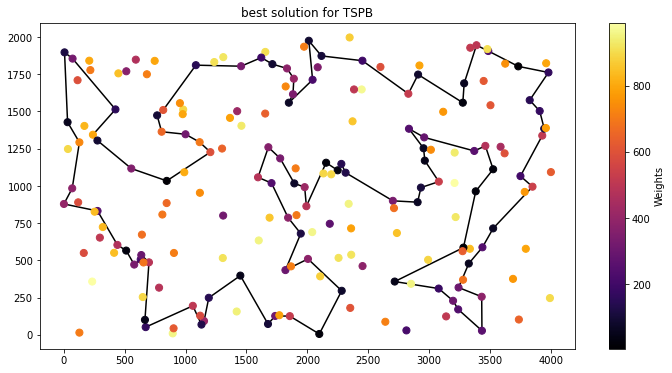

In [56]:
random_solutions = [get_random_solution(200) for _ in range(200)]
edgeNeighborhood = EdgeNeighborhood(distb, costsb, 100)
interNeighborhood = InterNeighborhood(distb, costsb, 100)
neighborhood1 = CombinedNeighborhood([edgeNeighborhood, interNeighborhood])
test_method(neighborhood1, random_solutions, distb, costsb, coordinatesb, 'TSPB')

scores:  72183 74626.54 78007
[101, 1, 97, 152, 2, 120, 44, 25, 16, 171, 175, 113, 56, 31, 78, 145, 92, 129, 57, 55, 52, 179, 81, 90, 165, 40, 185, 106, 178, 3, 49, 14, 144, 62, 9, 15, 148, 167, 124, 94, 63, 79, 80, 176, 137, 23, 89, 183, 143, 0, 117, 93, 68, 46, 115, 139, 41, 193, 159, 69, 108, 18, 22, 34, 54, 10, 177, 48, 160, 181, 42, 5, 43, 116, 65, 47, 184, 84, 4, 112, 35, 131, 149, 123, 127, 162, 72, 59, 118, 51, 151, 133, 135, 70, 154, 180, 53, 26, 86, 75]
execution time: 0.8439569473266602 1.0524138355255126 1.5050535202026367


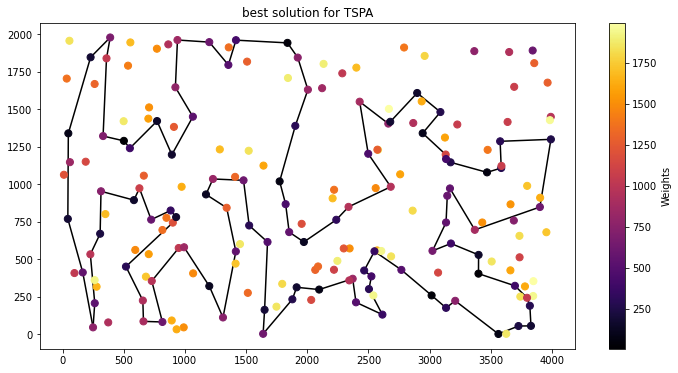

In [39]:
random_solutions = [get_random_solution(200) for _ in range(200)]
edgeNeighborhood = EdgeNeighborhood(dist, costs,100)
interNeighborhood = InterNeighborhood(dist, costs, 100)
neighborhood1 = CombinedNeighborhood([edgeNeighborhood, interNeighborhood])
test_method(neighborhood1, random_solutions, dist, costs, coordinates, 'TSPA')